# Estimer la tendance centrale : le cas de la poutre en flexion


## Déviation  verticale d'une poutre encastrée

We consider a cantilever beam defined by its Young’s modulus $E$, its length $L$ and its section modulus $I$. One end is built in a wall and we apply a concentrated bending load $F$ at the other end of the beam, resulting in a vertical deviation $Y$.

<img src="poutre.png" width="200">

__Inputs__:  $\left\{ E, F, L, I \right\}$

* $E$ : Young modulus (Pa)
* $F$ : Loading (N),
* $L$ : Length of beam (cm),
* $I$ : Moment of inertia (cm^4).

|Variable|  Distribution|
| ------------- |-------------|
|E|  Beta(r = 0.9, t = 3.5, a = $2.5\times 10^7$, $b = 5\times 10^7$) |
|F| Lognormal($\mu_F=3 \times 10^4$, $\sigma_F=9\times 10^3$, shift=$15\times 10^3$)|
|L|Uniform(min=250.0, max= 260.0)|
|I| Beta(r = 2.5, t = 4.0, a = 310, b = 450)|

In the previous table $\mu_F=E(F)$ and $\sigma_F=\sqrt{V(F)}$ are the mean and the standard deviation of $F$.

The input variables are supposed to be independent.

__Output__:

The vertical displacement at free end of the cantilever beam is:
$$
Y  = \dfrac{F\, L^3}{3 \, E \, I}
$$

## Définition du modèle

In [1]:
import openturns as ot
import numpy as np

On commence par définir les lois marginales.

In [2]:
dist_E = ot.Beta(0.9, 3.1, 2.8e7, 4.8e7)
dist_E.setDescription(["E"])
F_para = ot.LogNormalMuSigma(3.0e4, 9.0e3, 15.0e3) # in N
dist_F = ot.ParametrizedDistribution(F_para)
dist_F.setDescription(["F"])
dist_L = ot.Uniform(250., 260.) # in cm
dist_L.setDescription(["L"])
dist_I = ot.Beta(2.5, 4, 310., 450.) # in cm^4
dist_I.setDescription(["I"])

Les variables sont indépendantes, de telle sorte que l'on a pas besoin de spécifier une copule.

In [3]:
distcoll = [dist_E, dist_F, dist_L, dist_I]
X = ot.ComposedDistribution(distcoll)

Puis on définit le modèle.

In [4]:
g = ot.SymbolicFunction( ["E","F","L","I"],["F* L^3 /  (3 * E * I)"])
g.setOutputDescription(["Y (cm)"])

Pour pouvoir exploiter au mieux les simulations, nous équipons la fonction d'un méchanisme d'historique.

In [5]:
g = ot.MemoizeFunction(g)

Enfin, nous définissons le vecteur aléatoire de sortie.

In [6]:
XRV = ot.RandomVector(X)
Y = ot.RandomVector(g, XRV)
Y.setDescription(['Y (cm)'])

## Par développement de Taylor

La classe `TaylorExpansionMoments` permet de réaliser le développement de Taylor. 

In [7]:
taylor = ot.TaylorExpansionMoments(Y)

La moyenne $E(Y)$ peut être estimée à l'ordre 1 avec `getMeanFirstOrder` ou bien à l'ordre 2 (c'est à dire en tenant compte des dérivées secondes) avec `getMeanSecondOrder`.

In [8]:
taylor.getMeanFirstOrder()[0]

12.339109534783237

In [9]:
taylor.getMeanSecondOrder()[0]

12.63262216382261

La variance peut être calculée à l'ordre 1 uniquement.

In [10]:
taylor.getCovariance()[0,0]

17.44155282353067

L'écart-type de la sortie peut être calculé en évaluant la racine carrée.

In [11]:
np.sqrt(taylor.getCovariance()[0,0])

4.176308516325233

Les facteurs d'importance $\eta_i$ peuvent être obtenus avec la méthode `getImportanceFactors` ou dessinés avec la méthode `drawImportanceFactors`.

In [12]:
importancefactors = taylor.getImportanceFactors()
importancefactors

class=PointWithDescription name=Unnamed dimension=4 description=[E,F,L,I] values=[0.153533,0.785641,0.0100685,0.050758]

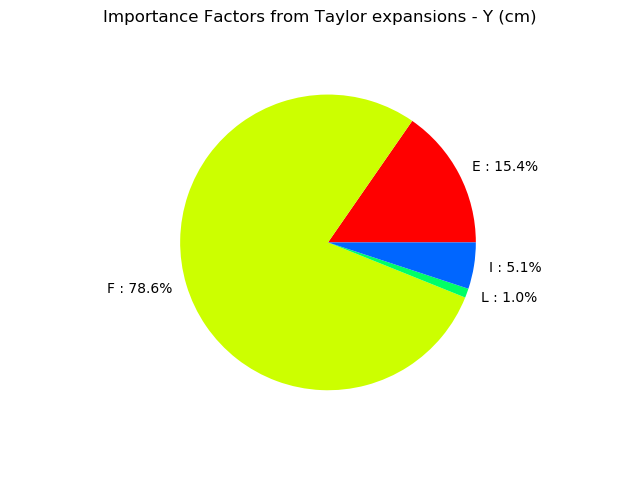

In [13]:
taylor.drawImportanceFactors()

On observe que la variabilité de la sortie $Y$ est principalement sensible à la variabilité de $F$ et, de manière moins importante par la variabilité de $E$. La variable $L$ pourrait être remplacée par une constante sans changer la variance de la sortie.

Une mise en garde s'impose au sujet des facteurs d'importance obtenus par la méthode `getImportanceFactors` : la dépendance éventuelle dans le vecteur aléatoire en entrée est ignorée. 

## Par Monte-Carlo simple avec un budget fixé

La manière la plus simple de faire une étude consiste à fixer le nombre de simulations à l'avance. En d'autres termes, on fixe $n$ et on génère un échantillon de la variable de sortie $Y$ de taille $n$. C'est la méthode "traditionnelle".

In [14]:
n = 10000

In [15]:
Ysample = Y.getSample(n)

La manière la plus simple d'observer la variabilité de la sortie consiste à tracer l'histogramme empirique.

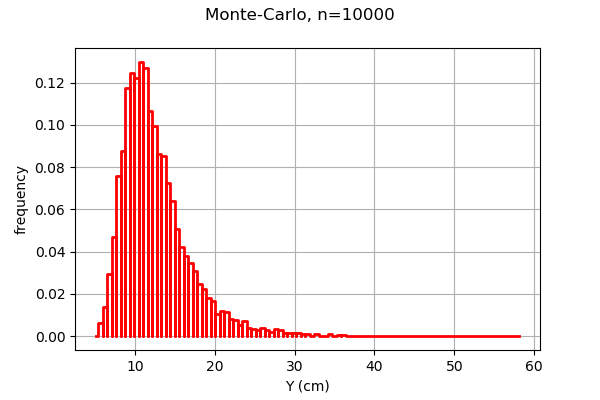

In [16]:
graph = ot.VisualTest_DrawHistogram(Ysample)
graph.setTitle("Monte-Carlo, n=%d" % (n))
graph.setXTitle("Y (cm)")
graph.setLegends([""])
graph

Les méthodes associées à l'échantillon permettent de d'estimer la moyenne et la variance.

In [17]:
Ysample.computeMean()[0]

12.62148787135405

In [18]:
Ysample.computeVariance()[0]

18.674969862358726

In [19]:
Ysample.computeStandardDeviationPerComponent()[0]

4.321454600288972

## Par Monte-Carlo simple avec un algorithme itératif

La méthode la plus performante consiste à utiliser la plus petite taille de l'échantillon possible assurant une précision déterminée. Pour cela, le plan d'expériences augmente de manière incrémentale, en mettant à jour la moyenne empirique. Pour améliorer la performance, les simulations sont réalisées avec une taille de bloc fixée par l'utilisateur. Lorsqu'on souhaite estimer la moyenne, c'est la méthode "moderne".

In [20]:
g.clearHistory()

In [21]:
algo = ot.ExpectationSimulationAlgorithm(Y)
algo.setMaximumOuterSampling(1000)
algo.setBlockSize(10)
algo.setMaximumCoefficientOfVariation(0.01)

In [22]:
algo.run()

In [23]:
result = algo.getResult()

In [24]:
outerSampleSize = result.getOuterSampling()
print("Number of iterations = %d" % (outerSampleSize))

Number of iterations = 118


In [25]:
expectation = result.getExpectationEstimate()
print("Mean = %f " % expectation[0])
blocksize = result.getBlockSize()
sampleSize = outerSampleSize * blocksize
print("Number of calls to G = %d" % (sampleSize))
cv = result.getCoefficientOfVariation()[0]
print("Coef. of var.=%.6f" % (cv))

Mean = 12.730356 
Number of calls to G = 1180
Coef. of var.=0.009962


The estimate of the mean has a known asymptotical gaussian distribution, which can be retrieved with the `getExpectationDistribution` method. 

Normal(mu = 12.7304, sigma = 0.126824)


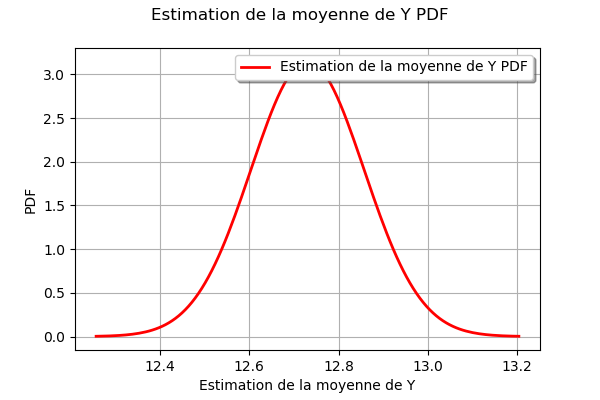

In [26]:
expectationDistribution = result.getExpectationDistribution()
expectationDistribution.setDescription(["Estimation de la moyenne de Y"])
print(expectationDistribution)
expectationDistribution.drawPDF()

In [27]:
Ysample = g.getOutputHistory()
sampleSize = Ysample.getSize()
print("Variance = %.4f" % (Ysample.computeVariance()[0]))

Variance = 18.9955


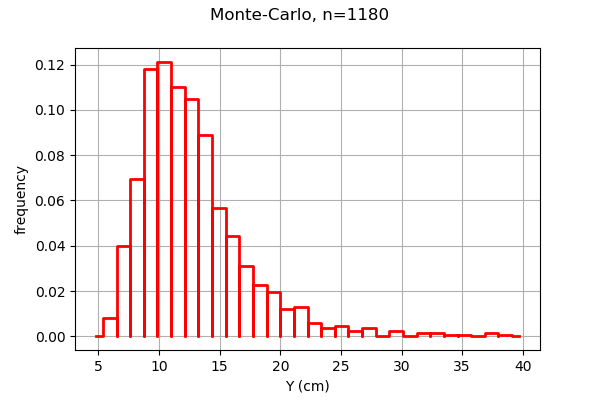

In [28]:
graph = ot.VisualTest_DrawHistogram(Ysample)
graph.setTitle("Monte-Carlo, n=%d" % (sampleSize))
graph.setXTitle("Y (cm)")
graph.setLegends([""])
graph

## Synthèse des résultats

| Méthode | Moyenne | Variance |
|--|--|--|
| Taylor, 1er ordre | 12.33 | 17.44 |
| Taylor, 2ème ordre | 12.63 | - |
| Monte-Carlo simple, n=10000 | 12.62 | 18.67 |
| Monte-Carlo itératif, n=1180 | 12.73 | 19.05 |


## Exercice 1 : vérifications du développement de Taylor

L'objectif de cet exercice est de vérifier que les méthodes de la librairie coïncident avec les formules que nous avons présenté précédemment pour l'estimation de moments par développement de Taylor.
- Utiliser la méthode `getMean` de la variable `X` pour créer la variable `muX` contenant le point moyen $\mu$ du vecteur aléatoire en entrée.
- Evaluer le modèle `g` au point `muX` et comparer avec la valeur de retour de la méthode `getMeanFirstOrder`.
- Utiliser la méthode `gradient` de la fonction `g` pour créer la variable `gradient` contenant la valeur du gradient de la fonction $g$ au point `muX`. 
- Utiliser la méthode `getCovariance` de la variable `X` pour créer la variable `covX` contenant la matrice de covariance diagonale du vecteur aléatoire en entrée. 
- Avec une boucle `for`, calculer la variance de la sortie `Y` en utilisant le développement de Taylor à l'ordre 1.
- Comparer le résultat précédent avec la valeur de retour de la méthode `getCovariance`.

## Exercice 2 : fixer une variable

On observe que le facteur d'importance associé à la variable $L$ est égal à 0.0100. Cela implique que, si on fixe cette variable à sa valeur moyenne, alors la variance va être peu modifiée. L'objectif de cet exercice est de le vérifier expérimentalement.
- Créer la variable `Lmean` contenant la valeur moyenne de la variable `dist_L` associée à $L$ grâce à la méthode `getMean`. 
- Créer la variable `L_fixed` contenant une distribution de type `Dirac` de paramètre `Lmean`. 
- Créer la distribution `Xfixed` associée au vecteur aléatoire dont la marginale $L$ est fixée. 
- Créer la variable `Yfixed` contenant le vecteur aléatoire de sortie associé. 
- Calculer la moyenne et la variance prédites par le développement de Taylor à l'ordre 1. 
- Comparer ces résultats avec les résultats du modèle précédent. 
- La perte de variance correspond-elle à la valeur du facteur d'importance ? Pourquoi ?

## Exercice 3 : développement de Taylor avec dépendance

On suppose que le problème est associé à une structure de dépendance gaussienne. Le coefficient de corrélation de Spearman (sur les rangs) est entre la longueur $L$ et le moment d'inertie $I$ est égal à 
$$
\rho_{rg}(L,I) = -0.2.
$$
L'objectif de cet exercice est d'observer comment cette dépendance peut affecter les moments estimés par développement de Taylor.

- Définir la copule associée à cette nouvelle structure de dépendance. Pour cela, créer la matrice de corrélation sur les rangs `smatrix` avec la classe `CorrelationMatrix`. 
- Créer la variable `matrix` contenant la matrice de corrélation de Pearson calculée grâce à la fonction `GetCorrelationFromSpearmanCorrelation` et de la matrice `smatrix`.
- Créer la variable `copula` contenant la copule gaussienne grâce à la classe `NormalCopula`.
- Créer la variable `Xgauss` contenant le vecteur aléatoire en entrée du modèle, puis le vecteur aléatoire de sortie correspondant `Ygauss`.
- Utiliser la classe `TaylorExpansionMoments` pour calculer la moyenne, l'écart-type et les facteurs d'importance de la sortie `Y`.
- Comparer les résultats numériques avec ceux sans dépendance. Comment expliquer les différences ?

## Exercice 4 : loi de la moyenne empirique

L'objectif de cet exercice est de vérifier la loi gaussienne de la moyenne empirique indiquée par le T.C.L.. Pour cela, nous considérons un échantillon Monte-Carlo simple de taille $n=100$. Cette faible taille d'échantillon est associée à une variabilité relativement importante de l'estimateur de la moyenne empirique. Puis nous allons réaliser $r$ estimations de la moyenne empirique. Nous allons ensuite comparer la distribution théorique et la distribution empirique. 
- Créer la variable `n=100`. 
- Générer un échantillon `Ysample` de taille `n` de la variable de sortie `Y`. Créer la variable `sigma` contenant l'écart-type empirique de cet échantillon. 
- Créer la variable `r=100`. 
- Créer la variable `meanSample` de type `Sample` de taille `r` en dimension 1.
- Avec une boucle `for`, répéter l'expérience suivante `r` fois. 
  - Générer un échantillon `Ysample` de taille `n` de la variable de sortie `Y`.
  - Stocker dans `meanSample[i,0]` la moyenne empirique de `Ysample`.
- Calculer `mu` la moyenne empirique de l'échantillon `meanSample`. 
- Créer la variable `M` de loi gaussienne de moyenne `mu` et d'écart-type `sigma/sqrt(n)`. 
- Dessiner l'histogramme empirique de l'échantillon `meanSample`. Dans le même graphique, dessiner la PDF de `M`.

- Optionnel : Utiliser la taille d'échantillon `n=400`. Quel est l'impact sur la distribution de la moyenne empirique ?